In [33]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [34]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [35]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [77]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
X1 = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    X1[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [01:13<00:00, 138.20it/s]


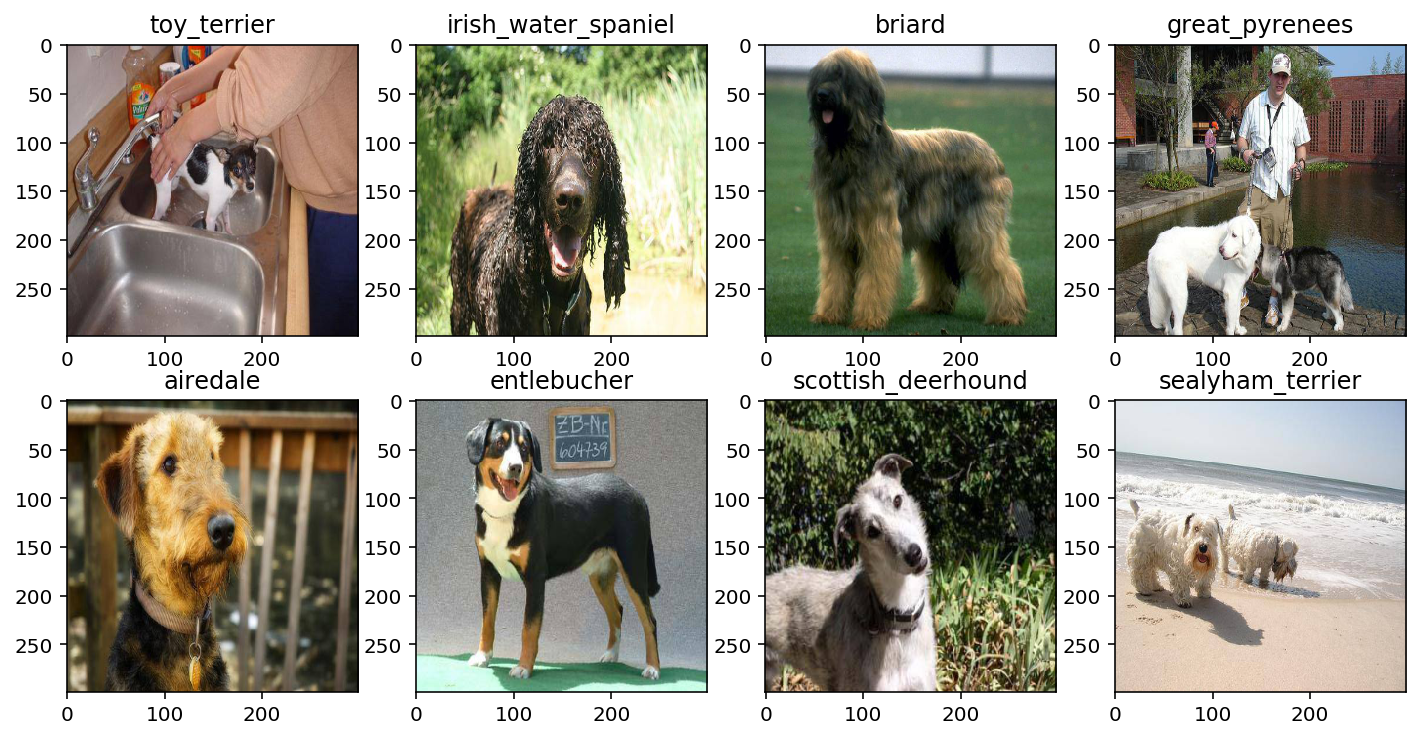

In [37]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [6]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [68]:
X.shape

(10222, 299, 299, 3)

In [69]:
X1=X

In [78]:
for i in range(len(X1)):
    X1[i]=np.fliplr(X1[i])

In [79]:
import numpy as np
X=np.concatenate((X, X1))

In [80]:
X.shape

(20444, 299, 299, 3)

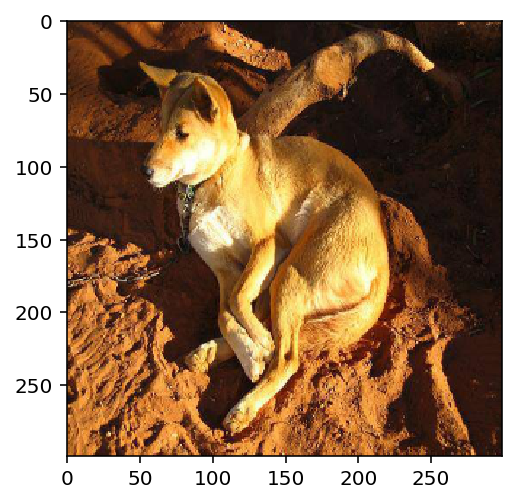

In [84]:
plt.imshow(X[1][:,:,::-1])

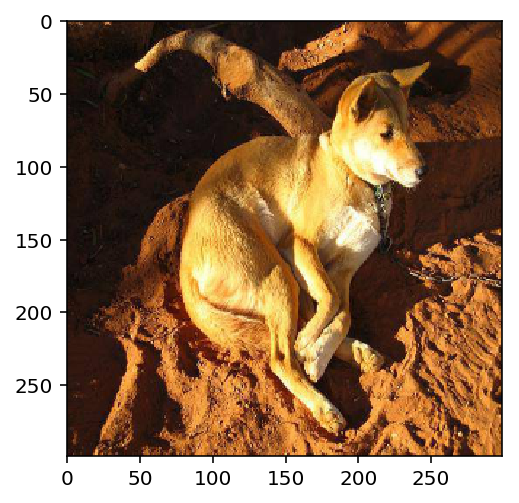

In [85]:
plt.imshow(X[10223][:,:,::-1])

In [83]:
y=np.concatenate((y, y))

In [86]:
y[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=uint8)

In [87]:
y[10223]==y[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [88]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [89]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

20444/20444 [==============================] - 17435s  


In [105]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=13, validation_split=0.15)

Train on 17377 samples, validate on 3067 samples
Epoch 1/13
17377/17377 [==============================] - 4s - loss: 1.3047 - acc: 0.7006 - val_loss: 0.5064 - val_acc: 0.8533
Epoch 2/13
17377/17377 [==============================] - 2s - loss: 0.4373 - acc: 0.8705 - val_loss: 0.3869 - val_acc: 0.8768
Epoch 3/13
17377/17377 [==============================] - 2s - loss: 0.3213 - acc: 0.9065 - val_loss: 0.3102 - val_acc: 0.9054
Epoch 4/13
17377/17377 [==============================] - 2s - loss: 0.2591 - acc: 0.9255 - val_loss: 0.2684 - val_acc: 0.9165
Epoch 5/13
17377/17377 [==============================] - 2s - loss: 0.2126 - acc: 0.9396 - val_loss: 0.2394 - val_acc: 0.9260
Epoch 6/13
17377/17377 [==============================] - 2s - loss: 0.1747 - acc: 0.9496 - val_loss: 0.1992 - val_acc: 0.9410
Epoch 7/13
17377/17377 [==============================] - 2s - loss: 0.1493 - acc: 0.9583 - val_loss: 0.1853 - val_acc: 0.9501
Epoch 8/13
17377/17377 [==============================] - 2s -

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

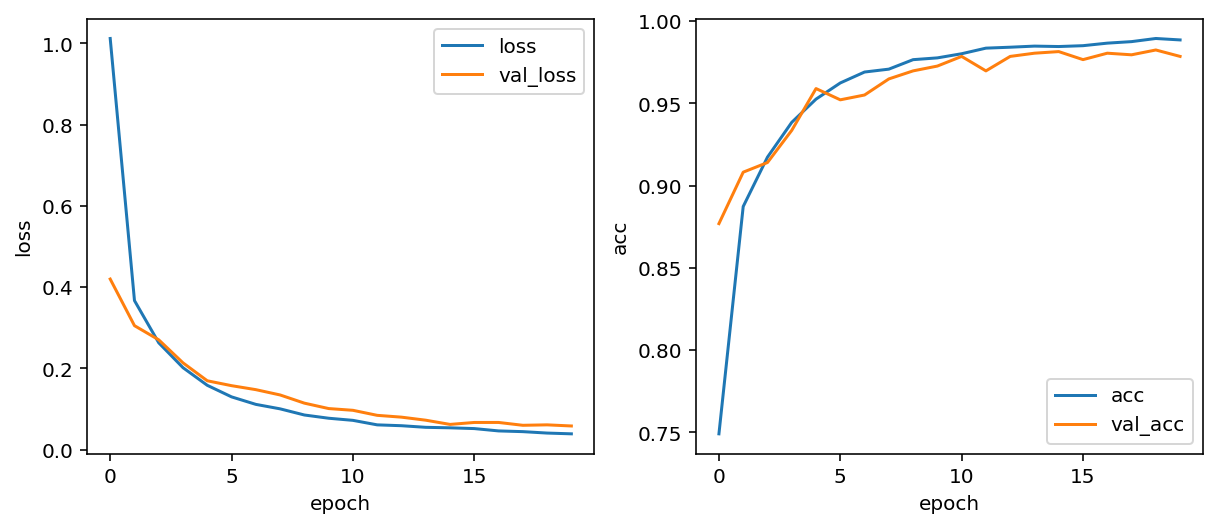

In [99]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [92]:
df2 = pd.read_csv('sample_submission.csv')

In [93]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('test/%s.jpg' % df2['id'][i]), (width, width))

100%|██████████| 10357/10357 [00:41<00:00, 251.68it/s]


In [94]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

10357/10357 [==============================] - 8904s   


In [106]:
y_pred = model.predict(features_test, batch_size=128)

In [107]:
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]

In [108]:
df2.to_csv('prediction1.csv', index=None)